In [1]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Conv2D, Input, Concatenate
from tensorflow.keras.applications import ResNet152V2, ResNet50V2
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.activations import sigmoid
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K
import gc
import skimage.io
import skimage.transform
import numpy as np

In [2]:
EXCEL_NAME = "ODIR-5K_Training_Annotations(Updated)_V2.xlsx"
IMAGE_WIDTH = 384
IMAGE_HEIGHT = 384
IMAGE_CHANNEL = 3
IMAGE_DIMS = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNEL)
NUM_CLASSES = 8
BATCH_SIZE = 12
NUM_EPOCHS = 10
LEFT_IMAGE_KEY = 'Left-Fundus'
RIGHT_IMAGE_KEY = 'Right-Fundus'
LABELS_KEY = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
TRAIN_DIRECTORY = 'ODIR-5K_Training_Dataset/'
TEST_DIRECTORY = 'ODIR-5K_Testing_Images/'

In [3]:
df = pd.read_excel(EXCEL_NAME)
df.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1
3,3,66,Male,3_left.jpg,3_right.jpg,normal fundus,branch retinal artery occlusion,0,0,0,0,0,0,0,1
4,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1


In [4]:
rightImagePaths = df[RIGHT_IMAGE_KEY].to_numpy()
leftImagePaths = df[LEFT_IMAGE_KEY].to_numpy()
data = np.stack([rightImagePaths, leftImagePaths]).T
labels = df[LABELS_KEY].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.33, random_state=42)

In [5]:
def loadAndCropCenterResize(imgPath, newSize):
    img= skimage.io.imread(imgPath)
    width, height, ______ = img.shape
    if width == height:
        return skimage.transform.resize(img, newSize)
    length = min(width, height)
    left = (width - length) // 2
    top = (height - length) // 2
    right = (width + length) // 2
    bottom = (height + length) // 2
    return skimage.transform.resize(img[left:right, top:bottom], newSize)


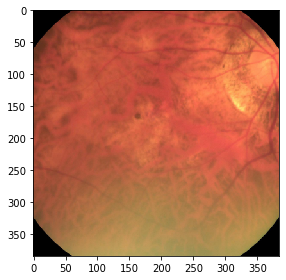

In [6]:
testImg = loadAndCropCenterResize("ODIR-5K_Training_Dataset/18_right.jpg", (IMAGE_WIDTH, IMAGE_HEIGHT))
skimage.io.imshow(testImg)
skimage.io.show()

In [7]:
def image_generator(filesRight,filesLeft, labels, directory, batch_size = 64):
    while True:
        batchPathsIdx  = np.random.randint(len(filesRight), size=batch_size)        
        dataRight = np.zeros((batch_size, *IMAGE_DIMS))
        dataLeft = np.zeros((batch_size, *IMAGE_DIMS))

        counter = 0
        for idx in batchPathsIdx:
            dataRight[counter, :, :, :] = loadAndCropCenterResize(directory + filesRight[idx], (IMAGE_WIDTH, IMAGE_HEIGHT))
            dataLeft[counter, :, :, :] = loadAndCropCenterResize(directory + filesLeft[idx], (IMAGE_WIDTH, IMAGE_HEIGHT))
            counter += 1

        # dataRight = preprocess_input(dataRight)
        # dataLeft = preprocess_input(dataLeft)
        yield ( [dataRight / 255.0, dataLeft / 255.0], labels[batchPathsIdx] )

In [ ]:
#One model version
K.clear_session()
gc.collect()
rightEyeInput = keras.Input(IMAGE_DIMS)
leftEyeInput = keras.Input(IMAGE_DIMS)
model = ResNet50V2(include_top=False, weights='imagenet', pooling='avg')
rightEye = model(rightEyeInput)
leftEye = model(leftEyeInput)
combined = Concatenate()([rightEye, leftEye])
out = Dense(NUM_CLASSES, activation='sigmoid')(combined)
model = Model([rightEyeInput, leftEyeInput], out)
model.summary()
model.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['accuracy']
              )

In [33]:
#Two model version
K.clear_session()
gc.collect()
rightEyeInput = keras.Input(IMAGE_DIMS)
leftEyeInput = keras.Input(IMAGE_DIMS)

rightEyemodel = ResNet50V2(input_tensor=rightEyeInput, include_top=False, weights='imagenet', pooling='avg')
leftEyemodel = ResNet50V2(input_tensor=leftEyeInput, include_top=False, weights='imagenet', pooling='avg')
rightEyemodel._name += "_right"
leftEyemodel._name += "_left"

combined = Concatenate()([rightEyemodel(rightEyeInput), leftEyemodel(leftEyeInput)])

out = Dense(NUM_CLASSES, activation='sigmoid')(combined)
model = Model([rightEyeInput, leftEyeInput], out)
model.summary()
model.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['accuracy']
              )

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 384, 384, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 384, 384, 3) 0                                            
__________________________________________________________________________________________________
resnet50v2_right (Model)        (None, 2048)         23564800    input_1[0][0]                    
__________________________________________________________________________________________________
resnet50v2_left (Model)         (None, 2048)         23564800    input_2[0][0]                    
______________________________________________________________________________________________

In [8]:
trainGen = image_generator(X_train[:, 0], X_train[:, 1], y_train, TRAIN_DIRECTORY, BATCH_SIZE)
valGen = image_generator(X_test[:, 0], X_test[:, 1], y_test, TRAIN_DIRECTORY, BATCH_SIZE)
weight_save_callback = keras.callbacks.ModelCheckpoint(
    '{epoch:02d}-{val_loss:.2f}.h5', 
    monitor='val_loss', 
    verbose=0, 
    save_best_only=False, 
    mode='auto'
    )

In [36]:
model.fit_generator(trainGen, epochs=NUM_EPOCHS, validation_data=valGen, callbacks = [weight_save_callback], steps_per_epoch = X_train.shape[0] / BATCH_SIZE, validation_steps = X_test.shape[0] / BATCH_SIZE)

NameError: name 'INIT_EPOCH' is not defined

In [9]:
K.clear_session()
gc.collect()
MODEL_PATH = '34-0.86.h5'
model = keras.models.load_model(MODEL_PATH)

In [ ]:
INIT_EPOCH = 10
model.fit_generator(trainGen, epochs=NUM_EPOCHS, validation_data=valGen, callbacks = [weight_save_callback], initial_epoch=INIT_EPOCH, steps_per_epoch = X_train.shape[0] / BATCH_SIZE, validation_steps = X_test.shape[0] / BATCH_SIZE)

In [16]:
# model.evaluate_generator(valGen, steps=200)

trainGenTest = image_generator(X_train[:, 0], X_train[:, 1], y_train, TRAIN_DIRECTORY, 400)
valGenTest = image_generator(X_test[:, 0], X_test[:, 1], y_test, TRAIN_DIRECTORY, 400)

for X, y in valGenTest:
    break



In [19]:
results = model.predict(X)

bin_results = results > 0.5
bin_y = y > 0.5
numcorrect = (bin_results == bin_y).sum()
total = bin_results.size

print(model.evaluate(X, y))
print(numcorrect, total)
print(numcorrect/total)

400/400 [==============================] - 5s 13ms/sample - loss: 0.8043 - accuracy: 0.8363
[0.8043311357498169, 0.83625]
2676 3200
0.83625
